In [7]:
from utils import *

import math
import torch
from torch import nn
from torch.nn import functional as F


# Text Data Processing

In [8]:
def download(name, cache_dir=os.path.join('data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    mkdir_if_not_exist(cache_dir)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    print("File location:", fname)
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [9]:
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

File location: data\timemachine.txt
# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [10]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [11]:
tokens = tokenize(lines, token='word')
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [12]:
tokens = tokenize(lines, token='char')
for i in range(11):
    print(tokens[i])

['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'b', 'y', ' ', 'h', ' ', 'g', ' ', 'w', 'e', 'l', 'l', 's']
[]
[]
[]
[]
['i']
[]
[]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 't', 'r', 'a', 'v', 'e', 'l', 'l', 'e', 'r', ' ', 'f', 'o', 'r', ' ', 's', 'o', ' ', 'i', 't', ' ', 'w', 'i', 'l', 'l', ' ', 'b', 'e', ' ', 'c', 'o', 'n', 'v', 'e', 'n', 'i', 'e', 'n', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'a', 'k', ' ', 'o', 'f', ' ', 'h', 'i', 'm']
['w', 'a', 's', ' ', 'e', 'x', 'p', 'o', 'u', 'n', 'd', 'i', 'n', 'g', ' ', 'a', ' ', 'r', 'e', 'c', 'o', 'n', 'd', 'i', 't', 'e', ' ', 'm', 'a', 't', 't', 'e', 'r', ' ', 't', 'o', ' ', 'u', 's', ' ', 'h', 'i', 's', ' ', 'g', 'r', 'e', 'y', ' ', 'e', 'y', 'e', 's', ' ', 's', 'h', 'o', 'n', 'e', ' ', 'a', 'n', 'd']
['t', 'w', 'i', 'n', 'k', 'l', 'e', 'd', ' ', 'a', 'n', 'd', ' ', 'h', 'i', 's', ' ', 'u', 's', 'u', 'a', 'l', 'l', 'y', ' ', 'p', 'a', 'l', 'e', ' ', 'f', 'a', 'c', 'e', ' ', 'w', 'a', 's', ' ', 'f

In [13]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [14]:
# We first tokenizing text lines into words
tokens = tokenize(lines, token='word')

# Then, we construct vocabulary with the tokens
vocab = Vocab(tokens)

# Print the first few frequent tokens in the vocab with their indices.
print(f"vocab (size:{len(vocab)}): {list(vocab.token_to_idx.items())[:10]}")

# We can convert each text line into a list of numerical indices
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

vocab (size:4580): [('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 3130, 3058, 438]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [4399, 3, 25, 1398, 387, 113, 7, 1676, 3, 1053, 1]


In [15]:
# We first tokenizing text lines into characeters
tokens = tokenize(lines, token='char')

# Then, we construct vocabulary with the tokens
vocab = Vocab(tokens)

# Print the first few frequent tokens in the vocab with their indices.
print(f"vocab (size:{len(vocab)}): {list(vocab.token_to_idx.items())[:]}")

# We can convert each text line into a list of numerical indices
for i in [0, 10]:
    print('characters:', tokens[i])
    print('indices:', vocab[tokens[i]])

vocab (size:28): [('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]
characters: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'b', 'y', ' ', 'h', ' ', 'g', ' ', 'w', 'e', 'l', 'l', 's']
indices: [3, 9, 2, 1, 3, 5, 13, 2, 1, 13, 4, 15, 9, 5, 6, 2, 1, 21, 19, 1, 9, 1, 18, 1, 17, 2, 12, 12, 8]
characters: ['t', 'w', 'i', 'n', 'k', 'l', 'e', 'd', ' ', 'a', 'n', 'd', ' ', 'h', 'i', 's', ' ', 'u', 's', 'u', 'a', 'l', 'l', 'y', ' ', 'p', 'a', 'l', 'e', ' ', 'f', 'a', 'c', 'e', ' ', 'w', 'a', 's', ' ', 'f', 'l', 'u', 's', 'h', 'e', 'd', ' ', 'a', 'n', 'd', ' ', 'a', 'n', 'i', 'm', 'a', 't', 'e', 'd', ' ', 't', 'h', 'e']
indices: [3, 17, 5, 6, 23, 12, 2, 11, 1, 4, 6, 11, 1, 9, 5, 8, 1, 14, 8, 14, 4, 12, 12, 

In [16]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [17]:
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

File location: data\timemachine.txt


(170580, 28)

In [18]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [19]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [20]:
my_seq = list(range(29))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('features: ', X, '\n labels:', Y)

features:  tensor([[ 1,  2,  3,  4,  5],
        [16, 17, 18, 19, 20]]) 
 labels: tensor([[ 2,  3,  4,  5,  6],
        [17, 18, 19, 20, 21]])
features:  tensor([[21, 22, 23, 24, 25],
        [11, 12, 13, 14, 15]]) 
 labels: tensor([[22, 23, 24, 25, 26],
        [12, 13, 14, 15, 16]])


In [21]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [22]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [23]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

File location: data\timemachine.txt


In [24]:
i=1
for x in train_iter:
    print(f'i={i}: {x[0].shape}')
    i+=1

i=1: torch.Size([32, 35])
i=2: torch.Size([32, 35])
i=3: torch.Size([32, 35])
i=4: torch.Size([32, 35])
i=5: torch.Size([32, 35])
i=6: torch.Size([32, 35])
i=7: torch.Size([32, 35])
i=8: torch.Size([32, 35])


# RNN Models

### RNN Model From Stracth

In [25]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

File location: data\timemachine.txt


In [26]:
def init_rnn_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [27]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [28]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    #print("Input shape:", inputs.shape)
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        #print("X shape:", X.shape)
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
        #print("Output at time step:", len(outputs))
    return torch.cat(outputs, dim=0), (H,)

In [29]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 init_rnn_params, init_rnn_state, rnn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = init_rnn_params(vocab_size, num_hiddens, device)
        self.init_state, self.rnn = init_rnn_state, rnn

    def __call__(self, inputs, state):
        # Transpose inputs shape into [num_steps, batch_size] and perform one-hot encoding
        # resulting a new X shape [num_steps, batch_size, vocab_size]
        X = F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
        return self.rnn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [30]:
# Configure the network with 256 hidden units
num_hiddens = 256
rnn_scratch = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), init_rnn_params,
                      init_rnn_state, rnn)

In [31]:
# Arbitary X with shape [batch_size, num_steps] as test input
batch_size=2
num_steps=5
X = torch.arange(batch_size*num_steps).reshape((batch_size, num_steps))

# Testing thet network outputs
state = rnn_scratch.begin_state(X.shape[0], try_gpu())
Y, new_state = rnn_scratch(X.to(try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 256]))


### Prediction

In [32]:
def predict_rnn(prefix, num_pred_chars, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    # Warm-up period
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # Predict characters
    for _ in range(num_pred_chars):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [33]:
predict_rnn('time traveller ', 10, rnn_scratch, vocab, try_gpu())

'time traveller oirhjckx <unk>'

### Gradient Clipping

In [34]:
def grad_clipping(net, theshold):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm_grad = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm_grad > theshold:
        for param in params:
            param.grad[:] *= theshold / norm_grad

### Training

In [35]:
def train_epoch_rnn(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        # Since the `mean` function has been invoked
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [36]:
def train_rnn(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_rnn(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_rnn(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.2, 33615.6 tokens/sec on cpu
time travellerit s against reason said filby but you willneverec
travelleridid a doas abofilithef courte domen it reared his


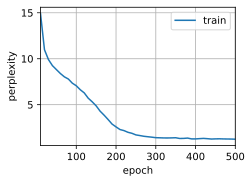

In [37]:
num_epochs, lr = 500, 1
train_rnn(rnn_scratch, train_iter, vocab, lr, num_epochs, try_gpu())

perplexity 1.4, 43281.3 tokens/sec on cpu
time traveller smiled rover tal another at fifteen another at se
traveller smiled rover a society said i erected on a strict


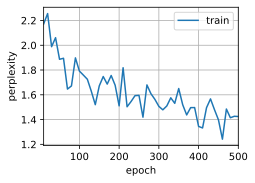

In [38]:
train_rnn(rnn_scratch, train_iter, vocab, lr, num_epochs, try_gpu(),
          use_random_iter=True)

## RNN Concise Model

In [39]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        return torch.zeros((self.rnn.num_layers, batch_size, self.num_hiddens), device=device)

In [40]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.RNN and nn.GRU takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [62]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [42]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 2, 256])

In [63]:
batch_size, num_steps = 32, 35
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

RuntimeError: Expected hidden size (1, 32, 256), got [1, 2, 256]

In [44]:
device=try_gpu()
rnn_concise = RNNModel(rnn_layer, vocab_size=len(vocab))
rnn_concise = rnn_concise.to(device)
predict_rnn('time traveller', 10, rnn_concise, vocab, device)

'time travellersonnnnnnnn'

perplexity 1.3, 45071.7 tokens/sec on cpu
time traveller but now you begin to seethe object of my investig
travellery cenlisibly stich he e matirnt of the batthe tion


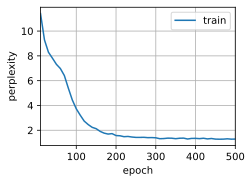

In [45]:
num_epochs, lr = 500, 1
train_rnn(rnn_concise, train_iter, vocab, lr, num_epochs, device)

perplexity 1.5, 12873.4 tokens/sec on cpu
time traveller held in his hand was a glitteringmetallic framewo
travelleryhe tine creiness waline oo convery pard dows ug t


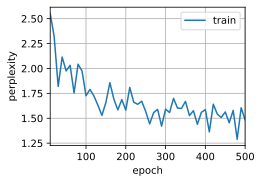

In [46]:
train_rnn(rnn_concise, train_iter, vocab, lr, num_epochs, device,
          use_random_iter=True)

# GRU Models

### GRU from Scratch

In [47]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

File location: data\timemachine.txt


In [48]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [49]:
def init_gru_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [50]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 12813.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travellerit would be remarkably convenient for the historia


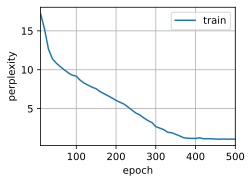

In [51]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
gru_scratch = RNNModelScratch(len(vocab), num_hiddens, device, init_gru_params,
                            init_gru_state, gru)
train_rnn(gru_scratch, train_iter, vocab, lr, num_epochs, device)

### GRU Concise

perplexity 1.1, 15510.9 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


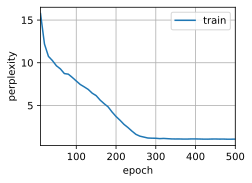

In [52]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
gru_concise = RNNModel(gru_layer, len(vocab))
gru_concise = gru_concise.to(device)
train_rnn(gru_concise, train_iter, vocab, lr, num_epochs, device)

# LSTM Models

### LSTM from Scratch

In [53]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

File location: data\timemachine.txt


In [55]:
def init_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [56]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [57]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 10314.7 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


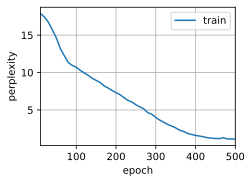

In [58]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
lstm_scratch = RNNModelScratch(len(vocab), num_hiddens, device, init_lstm_params,
                            init_lstm_state, lstm)
train_rnn(lstm_scratch, train_iter, vocab, lr, num_epochs, device)

### LSTM Concise

perplexity 1.0, 10841.6 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


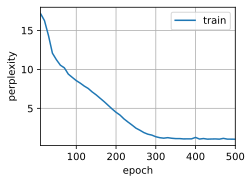

In [59]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
lstm_concise = RNNModel(lstm_layer, len(vocab))
lstm_concise = lstm_concise.to(device)
train_rnn(lstm_concise, train_iter, vocab, lr, num_epochs, device)